In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

from sklearn.ensemble import RandomForestRegressor

### Data Collection and Basic checks

In [3]:
# Read input
df = pd.read_csv("train.csv")
df.shape

(1460, 81)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Cleaning

In [7]:
# Split features and target
y = df["SalePrice"]
x = df.drop(columns=["SalePrice", "Id"], errors="ignore")

# find number of numeric and categorical columns
print(x.select_dtypes(include="number").shape, "numeric")
print(x.select_dtypes(exclude="number").shape, "categorical")

# find nulls
x.isna().sum().sort_values(ascending=False).head(20)

(1460, 36) numeric
(1460, 43) categorical


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageQual        81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
KitchenAbvGr       0
dtype: int64

In [8]:
# Drop columns with lots of null values
x.drop(['PoolQC', 'Alley', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [9]:
# Filling numerical nulls with median or 0
x['LotFrontage'] = x['LotFrontage'].fillna(x['LotFrontage'].median())
x['MasVnrArea'] = x['MasVnrArea'].fillna(0)
x['GarageYrBlt'] = x['GarageYrBlt'].fillna(0)

In [10]:
# Filling categorical nulls with mode
x['Electrical'] = x['Electrical'].fillna(df['Electrical'].mode()[0])

In [11]:
# Filling meaningfull nulls with NA
for i in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond']:
    x[i] = x[i].fillna('NA')

In [12]:
# ensuring non-null values are all removed
x.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 75, dtype: int64

In [13]:
# Checking for duplicates
x.duplicated().sum()

0

### Train/Test Split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Preprocessing
##### Encoding and Scaling
##### Categorical - OneHotEncoder and Numerical - StandardScaler

In [17]:
# --- Separate num and cat ---
num_cols = x_train.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = x_train.select_dtypes(exclude=["int64","float64"]).columns.tolist()

# MSSubClass looks numeric but is categorical
if "MSSubClass" in num_cols:
    num_cols.remove("MSSubClass")
    cat_cols.append("MSSubClass")

In [18]:
# --- Scale numeric ---
scaler = StandardScaler()
x_train_num = scaler.fit_transform(x_train[num_cols])
x_test_num = scaler.transform(x_test[num_cols])

# --- Encode categorical ---
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
x_train_cat = ohe.fit_transform(x_train[cat_cols])
x_test_cat = ohe.transform(x_test[cat_cols])

In [19]:
# --- Combine back ---
x_train_final = np.hstack([x_train_num, x_train_cat])
x_test_final = np.hstack([x_test_num, x_test_cat])

print("Final Train Shape:", x_train_final.shape)
print("Final Test Shape:", x_test_final.shape)

Final Train Shape: (1168, 297)
Final Test Shape: (292, 297)


## MODELS

### Linear Regression

In [22]:
lr = LinearRegression()
lr.fit(x_train_final, y_train)

y_pred = lr.predict(x_test_final)

print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 Score: -9.744077427752421e+17
MSE: 7.47402524589499e+27


Observation: R2 score does not look right. Features are exploding? Checking with numerical and categorical columns separately.

In [24]:
lr = LinearRegression()
lr.fit(x_train_num, y_train)
print("Numerical Baseline R2:", r2_score(y_test, lr.predict(x_test_num)))

Numerical Baseline R2: 0.8263097719645488


In [25]:
lr = LinearRegression()
lr.fit(x_train_cat, y_train)
print("Categorical Baseline R2:", r2_score(y_test, lr.predict(x_test_cat)))

Categorical Baseline R2: -3.182076774281454e+22


Observation: Numerical columns have a good baseline. Maybe OHE is leading to multicollinearity.

Next step: Regularization - Lasso and Ridge.

### Lasso and Ridge Regularizations

In [28]:
ridge = Ridge(alpha=10)
ridge.fit(x_train_final, y_train)
print("Ridge R2:", r2_score(y_test, ridge.predict(x_test_final)))

Ridge R2: 0.8781497350094405


In [29]:
lasso = Lasso(alpha=0.01, max_iter=50000)
lasso.fit(x_train_final, y_train)
print("Lasso R2:", r2_score(y_test, lasso.predict(x_test_final)))

Lasso R2: 0.8954026436199282


C:\Users\poovi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.665e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Observation: Regularization rectified the multicollinearity issue. R2 is significantly better.
- Numerical Baseline R2: 0.8263097719645488
- Ridge R2: 0.8781497350094405
- Lasso R2: 0.8954026436199282

Let's check a Tree model.

### RandomForest

In [32]:
rf = RandomForestRegressor(
    n_estimators=200,   # number of trees
    max_depth=None,     # let trees expand fully
    random_state=42,
    n_jobs=-1           # use all CPU cores
)

rf.fit(x_train_final, y_train)
y_pred_rf = rf.predict(x_test_final)

print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))

Random Forest R2: 0.8923986049801698
Random Forest MSE: 825337800.150498


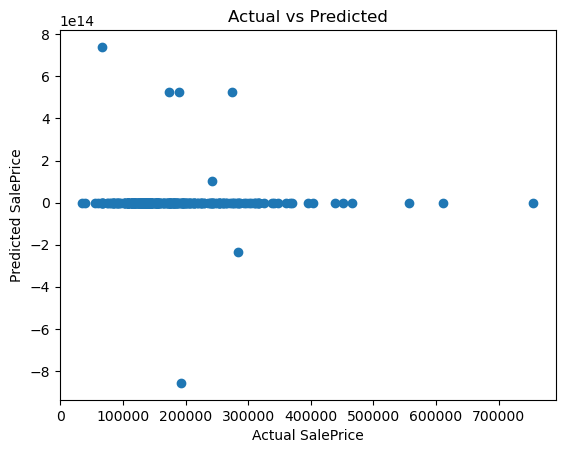

In [33]:
# Visualization
plt.scatter(y_test, y_pred)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted")
plt.show()

Observation: Random Forest is as good as Lasso

### GridSearchCV for hyperparameter tuning

In [36]:
param_grid = {
    "Ridge": {
        "model": Ridge(),
        "params": {
            "alpha": [0.01, 0.1, 1, 10, 50, 100]
        }
    },
    "Lasso": {
        "model": Lasso(max_iter=5000),
        "params": {
            "alpha": [0.001, 0.01, 0.1, 1, 10]
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20]
        }
    }
}

In [37]:
results = []

for name, mp in param_grid.items():
    print(f"\nTuning {name}...")
    grid = GridSearchCV(
        estimator=mp["model"],
        param_grid=mp["params"],
        cv=5,
        scoring="r2",
        n_jobs=-1
    )
    grid.fit(x_train_final, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(x_test_final)
    
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "CV Best R2": grid.best_score_,
        "Test R2": r2_score(y_test, y_pred),
        "Test MSE": mean_squared_error(y_test, y_pred)
    })


Tuning Ridge...

Tuning Lasso...

Tuning RandomForest...


In [38]:
df_results = pd.DataFrame(results)
print(df_results)

          Model                               Best Params  CV Best R2  \
0         Ridge                             {'alpha': 10}    0.816777   
1         Lasso                             {'alpha': 10}    0.780983   
2  RandomForest  {'max_depth': None, 'n_estimators': 100}    0.841760   

    Test R2      Test MSE  
0  0.878150  9.346313e+08  
1  0.899246  7.728146e+08  
2  0.891965  8.286626e+08  


Lasso is still the best model.

The best alpha for both Ridge and Lasso is 10.

The best n_estimators for RandomForest is 100.

The R2 values did not change significantly.